In [1]:
import sys
sys.path.append("../")
from utils import load_cnf, cnf_to_bqm
from embedding_utils import *
import seaborn as sns
from redundancy import *
from utils import *
from dwave.embedding.chain_strength import scaled
import pandas as pd
from brute_force import get_bqm_random_sat
import numpy as np
import matplotlib.pyplot as plt

Tests for 8-bit inputs multiplication

In [99]:
from math import sqrt

def get_count_answers(n, wordsize):
    if n == 0:
        return 2*(2**wordsize)
    
    answer = set()
    for i in range(1, int(sqrt(n))+1):
        if n % i == 0:
            div = n//i
            answer.add((div, n/div))
            answer.add((n/div, div))
    return len(answer)

def get_normalized_distribution_wordsize(wordsize, bottom=0):
    search_space_size = 2**(wordsize*2)    
    count_answers = []
    for i in range(bottom,2**wordsize):
        count_answers.append(get_count_answers(i, wordsize)/search_space_size)
    print(wordsize, ":", sum(count_answers)/len(count_answers))
    return count_answers


def get_distribution_wordsize(wordsize, bottom=0):
    search_space_size = 2**(wordsize*2)    
    count_answers = []
    for i in range(bottom,2**wordsize):
        count_answers.append(get_count_answers(i, wordsize))
    print(wordsize, ":", sum(count_answers)/len(count_answers))
    return count_answers


In [101]:
probs8 = get_normalized_distribution_wordsize(8)
probs16 = get_normalized_distribution_wordsize(16)

8 : 0.00011736154556274414
16 : 3.08385850189552e-09


In [91]:
divisors8 = get_distribution_wordsize(8)
divisors16 = get_distribution_wordsize(16)

8 : 7.69140625
16 : 13.245071411132812


In [120]:
x = [i for i in range(0, 2**8)]

In [133]:
df.count_answers.sort_values().unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  12,  14,  15,
        16,  18,  20, 512])

In [142]:
def get_vertices_degrees(bqm):
    answer = []
    for (node, neighbours) in bqm.adj.items():
        answer.append(len(neighbours)) 
    return answer

qubo_vars = []
cnf_vars = []
clauses_to_var_rels = []
max_chain_lengths = []
variances_chain_lengths = []
avgs_chain_lengths = []

for n in x:
    bqm, estimated_num_variables = unicorn_file_parser(f"./mul_experiments/qubos/{n}.unicorn")
    vertices_degrees = get_vertices_degrees(bqm)
    avg_degrees = round(float(sum(vertices_degrees))/float(len(vertices_degrees)),2)
    variance_degrees = round(variance(vertices_degrees),2)
    num_variables, num_clauses, variables, clauses = load_cnf(f"./mul_experiments/cnfs/{n}.cnf")
    
    qubo_vars.append(len(bqm.variables))
    cnf_vars.append(num_variables)
    clauses_to_var_rels.append(num_clauses/num_variables)
    max_chain_lengths.append(max(vertices_degrees))
    variances_chain_lengths.append(variance_degrees)
    avgs_chain_lengths.append(avg_degrees)

df = pd.DataFrame({
    'n': x,
    'count_answers': divisors8,
    'qubo_vars': qubo_vars,
    'max_chain_length': max_chain_lengths,
    'variance_chain_length': variances_chain_lengths,
    'avg_chain_length': avgs_chain_lengths,
    'cnf_vars': cnf_vars,
    'clauses_per_var': clauses_to_var_rels,
    'sat_ratio': probs8,
})

In [150]:
df.describe()

,n,count_answers,qubo_vars,max_chain_length,variance_chain_length,avg_chain_length,cnf_vars,clauses_per_var,sat_ratio
count,256.000000,256.000000,256.000000,256.0,256.000000,256.000000,256.000000,256.000000,256.000000
mean,127.500000,7.691406,146.000000,16.0,5.309297,5.343633,119.000000,4.159969,0.000117
std,74.045031,31.843405,1.416984,0.0,0.039915,0.032559,1.416984,0.025729,0.000486
min,0.000000,1.000000,142.000000,16.0,5.180000,5.250000,115.000000,4.089431,0.000015
25%,63.750000,4.000000,145.000000,16.0,5.280000,5.320000,118.000000,4.141667,0.000061
50%,127.500000,4.000000,146.000000,16.0,5.310000,5.340000,119.000000,4.159664,0.000061
75%,191.250000,8.000000,147.000000,16.0,5.340000,5.370000,120.000000,4.177966,0.000122
max,255.000000,512.000000,150.000000,16.0,5.410000,5.440000,123.000000,4.234783,0.007812


In [168]:
# try: 0,1,2,4,8,16,512
df[(df.count_answers==1)]

,n,count_answers,qubo_vars,max_chain_length,variance_chain_length,avg_chain_length,cnf_vars,clauses_per_var,sat_ratio
1,1,1,149,16,5.39,5.28,122,4.106557,0.000015


In [169]:
df[(df.count_answers==2) & (df.qubo_vars == 149)]

,n,count_answers,qubo_vars,max_chain_length,variance_chain_length,avg_chain_length,cnf_vars,clauses_per_var,sat_ratio
2,2,2,149,16,5.39,5.28,122,4.106557,0.000031


In [170]:
df[(df.count_answers==4) & (df.qubo_vars == 149)]

,n,count_answers,qubo_vars,max_chain_length,variance_chain_length,avg_chain_length,cnf_vars,clauses_per_var,sat_ratio
8,8,4,149,16,5.39,5.28,122,4.106557,0.000061


In [171]:
df[(df.count_answers==8) & (df.qubo_vars == 149)]

,n,count_answers,qubo_vars,max_chain_length,variance_chain_length,avg_chain_length,cnf_vars,clauses_per_var,sat_ratio
128,128,8,149,16,5.38,5.28,122,4.106557,0.000122


In [181]:
df[(df.count_answers==16)& (df.qubo_vars == 147)]

,n,count_answers,qubo_vars,max_chain_length,variance_chain_length,avg_chain_length,cnf_vars,clauses_per_var,sat_ratio
168,168,16,147,16,5.33,5.32,120,4.141667,0.000244


In [155]:
df[(df.count_answers==512)]

,n,count_answers,qubo_vars,max_chain_length,variance_chain_length,avg_chain_length,cnf_vars,clauses_per_var,sat_ratio
0,0,512,150,16,5.41,5.25,123,4.089431,0.007812


<AxesSubplot:xlabel='n', ylabel='qubo_vars'>

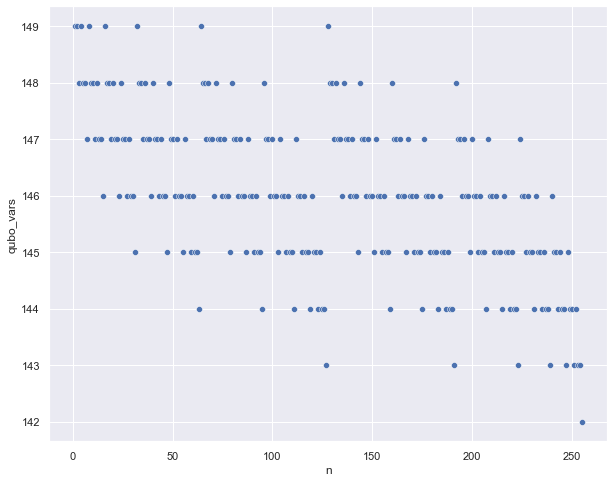

In [192]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("darkgrid")
sns.scatterplot(data=df[df.n > 0],x="n", y="qubo_vars")



In [200]:
from statistics import variance
from greedy import SteepestDescentSolver
qpu = get_qpu()
quimera_qpu = DWaveSampler(solver={"name": "DW_2000Q_6"})
solver_greedy = SteepestDescentSolver()

In [201]:
nfiles_to_try = [0,1,2,8,128,168]

In [202]:
df[df.n == 0]

,n,count_answers,qubo_vars,max_chain_length,variance_chain_length,avg_chain_length,cnf_vars,clauses_per_var,sat_ratio
0,0,512,150,16,5.41,5.25,123,4.089431,0.007812


In [221]:
def get_file_bqm(file_name):
    bqm, estimated_num_variables = unicorn_file_parser(f"./mul_experiments/qubos/{file_name}.unicorn")
    vertices_degrees = get_vertices_degrees(bqm)
    avg_degrees = round(float(sum(vertices_degrees))/float(len(vertices_degrees)),2)
    variance_degrees = round(variance(vertices_degrees),2)
    
    num_variables, num_clauses, variables, clauses = load_cnf(f"./mul_experiments/cnfs/{file_name}.cnf")
    print(f"file: {file_name}")
    print(f"cnf vars, clauses, clauses_to_var = {num_variables}, {num_clauses}, {round(num_clauses/num_variables,2)}")
    print(f"qubo vars {len(bqm.variables)}")
    print(f"conn avg, variance, max = {avg_degrees}, {variance_degrees}, {max(vertices_degrees)}")
    
    return bqm

def get_input_value(sample, one_input):
    answer = 0
    for (index,element) in enumerate(one_input):
        answer+= (sample[element])*(2**index)
    return int(answer)

def get_input_values(sample, input_ids):
    answer = []
    
    for i in input_ids:
        answer.append(get_input_value(sample, i))
    return ','.join([str(x) for x in answer]) 

def get_results_dataframe(file, input_ids, reads=100, bottom=0.25, top=5, is_pegasus=True, is_chimera=True, is_local_search=True, random_seed_pegasus=None,random_seed_chimera=None):
    bqm = get_file_bqm(file)
    
    
    
    chain_strengths = []
    energies = []
    input_vals = []
    file_name = []
    sampleset_types = []
    qpus = []
    if is_pegasus:
        if random_seed_pegasus:
            embedding_1 = get_embedding(bqm, qpu, random_seed=random_seed_pegasus)
        else:
            embedding_1, random_seed = find_best_embedding(bqm, qpu)
        sampler = FixedEmbeddingComposite(qpu, embedding_1)
        for chain_strength in list(np.arange(bottom, top + 0.25, 0.25)):
            
            sampleset = sampler.sample(bqm, num_reads=reads, chain_strength=chain_strength, auto_scale=True, answer_mode='raw')
            assert(len(sampleset) == reads)
            print("advantage:",chain_strength, "raw", sampleset.first.energy)
            for sample in sampleset:
                file_name.append(file)
                chain_strengths.append(chain_strength)
                energies.append(bqm.energy(sample))
                sampleset_types.append("raw")
                qpus.append("Advantage4.1")
                input_vals.append(get_input_values(sample, input_ids))

            if is_local_search:
                sampleset_pp = solver_greedy.sample(bqm, initial_states=sampleset)
                print(chain_strength, "pp_local_search", sampleset.first.energy)
                for sample in sampleset_pp:
                    file_name.append(file)
                    chain_strengths.append(chain_strength)
                    energies.append(bqm.energy(sample))
                    input_vals.append(get_input_values(sample, input_ids))
                    qpus.append("Advantage4.1")
                    sampleset_types.append("pp_local_search")
                print("************")
    if is_chimera:
        if random_seed_chimera is None:
            embedding_2, random_seed = find_best_embedding(bqm, quimera_qpu)
        else:
            embedding_2 = get_embedding(bqm, quimera_qpu, random_seed=random_seed_chimera)
        sampler = FixedEmbeddingComposite(quimera_qpu, embedding_2)
        for chain_strength in list(np.arange(bottom, top + 0.25, 0.25)):
            print("reads:",reads)
            sampleset = sampler.sample(bqm, num_reads=reads, chain_strength=chain_strength, auto_scale=True, answer_mode='raw')
            assert(len(sampleset) == reads)
            print('chimera:',chain_strength, "raw", sampleset.first.energy)
            for sample in sampleset:
                file_name.append(file)
                chain_strengths.append(chain_strength)
                energies.append(bqm.energy(sample))
                sampleset_types.append("raw")
                qpus.append("DW_2000Q_6")
                input_vals.append(get_input_values(sample, input_ids))
            if is_local_search:
                sampleset_pp = solver_greedy.sample(bqm, initial_states=sampleset)
                print(chain_strength, "pp_local_search", sampleset.first.energy)
                for sample in sampleset_pp:
                    file_name.append(file)
                    chain_strengths.append(chain_strength)
                    energies.append(bqm.energy(sample))
                    input_vals.append(get_input_values(sample, input_ids))
                    qpus.append("DW_2000Q_6")
                    sampleset_types.append("pp_local_search")
                print("************")
        
    return pd.DataFrame({
        'file': file_name,
        'type': sampleset_types,
        'chain_strength': chain_strengths,
        'energy': energies,
        'input_values': input_vals,
        'qpu': qpus
    })

In [213]:
# input_ids = [[2,6,15,28,45,66,91,120],[3,8,21,38,59,84,113,146]]
# result_df = get_results_dataframe("0", input_ids)
# result_df.to_csv("./mul_experiments/outputs/0_100.csv")
result_df

<AxesSubplot:xlabel='chain_strength', ylabel='energy'>

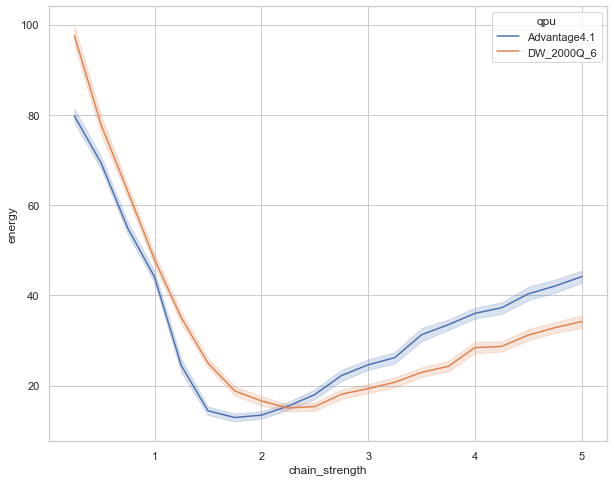

In [207]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("whitegrid", {'axes.grid' : True})
sns.lineplot(data=result_df[result_df.type=='raw'], x="chain_strength", y="energy", hue="qpu")

In [211]:
result_df[(result_df.qpu == "Advantage4.1") & (result_df.type=='raw')].describe()

,chain_strength,energy
count,2000.000000,2000.000000
mean,2.625000,34.206000
std,1.441931,18.888938
min,0.250000,4.000000
25%,1.437500,20.000000
50%,2.625000,32.000000
75%,3.812500,44.000000
max,5.000000,110.000000


In [212]:
result_df[(result_df.qpu != "Advantage4.1") & (result_df.type=='raw')].describe()

,chain_strength,energy
count,2000.000000,2000.000000
mean,2.625000,33.634000
std,1.441931,22.485525
min,0.250000,4.000000
25%,1.437500,18.000000
50%,2.625000,26.000000
75%,3.812500,38.000000
max,5.000000,124.000000


In [215]:
input_ids = [[2,6,15,28,45,66,91,120],[3,8,21,38,59,84,113,146]]
result_df = get_results_dataframe("0", input_ids, reads=500, bottom=1.25, top=2.75)
result_df.to_csv("./mul_experiments/outputs/0_500.csv")
result_df

file: 0
cnf vars, clauses, clauses_to_var = 123, 503, 4.09
qubo vars 150
conn avg, variance, max = 5.25, 5.41, 16
best embedding random_seed 23
best embedding max_chain_length 5
best embedding qubits used 279
best embedding variance: 0.8460402684563758
advantage: 1.25 raw 8.0
1.25 pp_local_search 8.0
************
advantage: 1.5 raw 4.0
1.5 pp_local_search 4.0
************
advantage: 1.75 raw 4.0
1.75 pp_local_search 4.0
************
advantage: 2.0 raw 2.0
2.0 pp_local_search 2.0
************
advantage: 2.25 raw 4.0
2.25 pp_local_search 4.0
************
advantage: 2.5 raw 6.0
2.5 pp_local_search 6.0
************
advantage: 2.75 raw 6.0
2.75 pp_local_search 6.0
************
best embedding random_seed 63
best embedding max_chain_length 11
best embedding qubits used 596
best embedding variance: 6.6838478747203585
reads: 500
chimera: 1.25 raw 18.0
1.25 pp_local_search 18.0
************
reads: 500
chimera: 1.5 raw 10.0
1.5 pp_local_search 10.0
************
reads: 500
chimera: 1.75 raw 4.0
1.

,file,type,chain_strength,energy,input_values,qpu
0,0,raw,1.25,8.0,"63,4",Advantage4.1
1,0,raw,1.25,10.0,"151,132",Advantage4.1
2,0,raw,1.25,10.0,"87,41",Advantage4.1
3,0,raw,1.25,10.0,"143,3",Advantage4.1
4,0,raw,1.25,12.0,"134,100",Advantage4.1
...,...,...,...,...,...,...
13995,0,pp_local_search,2.75,30.0,"236,152",DW_2000Q_6
13996,0,pp_local_search,2.75,30.0,"129,219",DW_2000Q_6
13997,0,pp_local_search,2.75,30.0,"105,190",DW_2000Q_6
13998,0,pp_local_search,2.75,32.0,"253,170",DW_2000Q_6


In [219]:
result_df[(result_df.qpu != "Advantage4.1") & (result_df.type=='raw')].describe()

,chain_strength,energy
count,3500.000000,3500.000000
mean,2.000000,20.182857
std,0.500071,8.445359
min,1.250000,4.000000
25%,1.500000,14.000000
50%,2.000000,18.000000
75%,2.500000,24.000000
max,2.750000,52.000000


In [222]:
input_ids = [[2,6,15,28,45,66,91,120],[3,8,21,38,59,84,113,146]]
result_df = get_results_dataframe("0", input_ids, reads=1000, bottom=1.5, top=2.25, random_seed_pegasus=23, is_chimera=False)
result_df.to_csv("./mul_experiments/outputs/0_1000.csv")
result_df

file: 0
cnf vars, clauses, clauses_to_var = 123, 503, 4.09
qubo vars 150
conn avg, variance, max = 5.25, 5.41, 16
advantage: 1.5 raw 4.0
1.5 pp_local_search 4.0
************
advantage: 1.75 raw 2.0
1.75 pp_local_search 2.0
************
advantage: 2.0 raw 2.0
2.0 pp_local_search 2.0
************
advantage: 2.25 raw 4.0
2.25 pp_local_search 4.0
************


,file,type,chain_strength,energy,input_values,qpu
0,0,raw,1.50,4.0,"152,187",Advantage4.1
1,0,raw,1.50,4.0,"143,155",Advantage4.1
2,0,raw,1.50,4.0,"75,11",Advantage4.1
3,0,raw,1.50,4.0,"183,4",Advantage4.1
4,0,raw,1.50,4.0,"175,142",Advantage4.1
...,...,...,...,...,...,...
7995,0,pp_local_search,2.25,24.0,"54,151",Advantage4.1
7996,0,pp_local_search,2.25,26.0,"88,103",Advantage4.1
7997,0,pp_local_search,2.25,26.0,"31,10",Advantage4.1
7998,0,pp_local_search,2.25,26.0,"91,27",Advantage4.1


In [224]:
input_ids = [[2,6,15,28,45,66,91,120],[3,8,21,38,59,84,113,146]]
result_df = get_results_dataframe("0", input_ids, reads=2000, bottom=1.75, top=2.0, random_seed_pegasus=23, is_chimera=False)
result_df.to_csv("./mul_experiments/outputs/0_2000.csv")
result_df

file: 0
cnf vars, clauses, clauses_to_var = 123, 503, 4.09
qubo vars 150
conn avg, variance, max = 5.25, 5.41, 16
advantage: 1.75 raw 2.0
1.75 pp_local_search 2.0
************
advantage: 2.0 raw 2.0
2.0 pp_local_search 2.0
************


,file,type,chain_strength,energy,input_values,qpu
0,0,raw,1.75,2.0,"59,235",Advantage4.1
1,0,raw,1.75,2.0,"185,155",Advantage4.1
2,0,raw,1.75,2.0,"58,49",Advantage4.1
3,0,raw,1.75,4.0,"148,94",Advantage4.1
4,0,raw,1.75,4.0,"42,213",Advantage4.1
...,...,...,...,...,...,...
7995,0,pp_local_search,2.00,24.0,"72,253",Advantage4.1
7996,0,pp_local_search,2.00,24.0,"146,94",Advantage4.1
7997,0,pp_local_search,2.00,26.0,"223,120",Advantage4.1
7998,0,pp_local_search,2.00,26.0,"185,120",Advantage4.1


In [226]:
input_ids = [[2,6,15,28,45,66,91,120],[3,8,21,38,59,84,113,146]]
result_df = get_results_dataframe("0", input_ids, reads=3000, bottom=1.75, top=2.0, random_seed_pegasus=23, is_chimera=False)
result_df.to_csv("./mul_experiments/outputs/0_3000.csv")
result_df

file: 0
cnf vars, clauses, clauses_to_var = 123, 503, 4.09
qubo vars 150
conn avg, variance, max = 5.25, 5.41, 16
advantage: 1.75 raw 2.0
1.75 pp_local_search 2.0
************
advantage: 2.0 raw 0.0
2.0 pp_local_search 0.0
************


,file,type,chain_strength,energy,input_values,qpu
0,0,raw,1.75,2.0,"151,78",Advantage4.1
1,0,raw,1.75,2.0,"183,199",Advantage4.1
2,0,raw,1.75,2.0,"252,1",Advantage4.1
3,0,raw,1.75,2.0,"105,149",Advantage4.1
4,0,raw,1.75,2.0,"192,62",Advantage4.1
...,...,...,...,...,...,...
11995,0,pp_local_search,2.00,24.0,"158,94",Advantage4.1
11996,0,pp_local_search,2.00,24.0,"175,99",Advantage4.1
11997,0,pp_local_search,2.00,24.0,"157,203",Advantage4.1
11998,0,pp_local_search,2.00,26.0,"95,244",Advantage4.1


In [227]:
result_df[result_df.energy == 0]

,file,type,chain_strength,energy,input_values,qpu
6000,0,raw,2.0,0.0,"165,0",Advantage4.1
9000,0,pp_local_search,2.0,0.0,"165,0",Advantage4.1


In [240]:
all_df = pd.DataFrame()
for sample_size in [100, 500, 1000, 2000, 3000]:
    df = pd.read_csv(f"./mul_experiments/outputs/0_{sample_size}.csv")
    df = df[df.type == "raw"]
    df = df[(df.chain_strength > 1) & (df.chain_strength < 3)]
    df = df[df.qpu == "Advantage4.1"]
    df["sample_size"] = sample_size
    df = df.drop(['Unnamed: 0', 'file', 'type', 'qpu'], axis=1)
    all_df = all_df.append(df)


In [241]:
all_df.shape

(18200, 4)

In [242]:
all_df

,chain_strength,energy,input_values,sample_size
800,1.25,6.0,"142,196",100
801,1.25,8.0,"87,6",100
802,1.25,10.0,"63,2",100
803,1.25,10.0,"70,195",100
804,1.25,10.0,"255,2",100
...,...,...,...,...
8995,2.00,30.0,"42,141",3000
8996,2.00,30.0,"95,158",3000
8997,2.00,32.0,"207,167",3000
8998,2.00,32.0,"144,222",3000


<AxesSubplot:xlabel='chain_strength', ylabel='energy'>

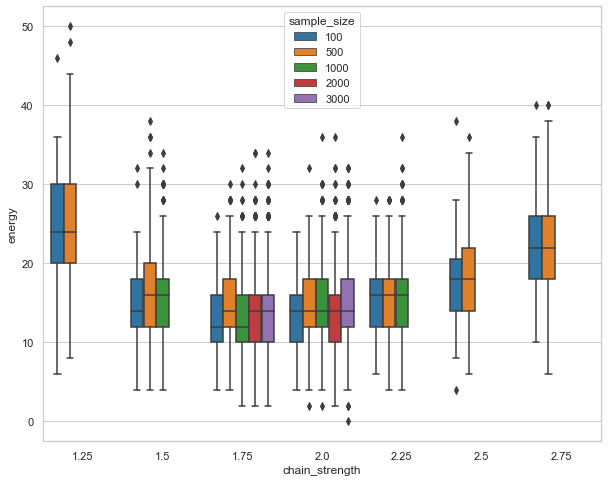

In [263]:
sns.set(rc={'figure.figsize':(10,8)})
sns.set_style("whitegrid", {'axes.grid' : True})
sns.boxplot(data=all_df, x="chain_strength", y="energy", hue="sample_size", palette=sns.color_palette('tab10', n_colors=5))